
# **Cats and dogs image classification**

In [1]:
import numpy as np
import pandas as pd 

import os
import zipfile 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import KFold
import pickle

## **Load the data**

In [2]:
# Get the data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/CatsDogs.zip'
  
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
print('The data set has been extracted.')

The data set has been extracted.


In [4]:
print("Cats photos :" +str(len(os.listdir('./../tmp/CatsDogs/Cats'))))
print("Dogs photos :" +str(len(os.listdir('./../tmp/CatsDogs/Dogs'))))

Cats photos :12500
Dogs photos :12500


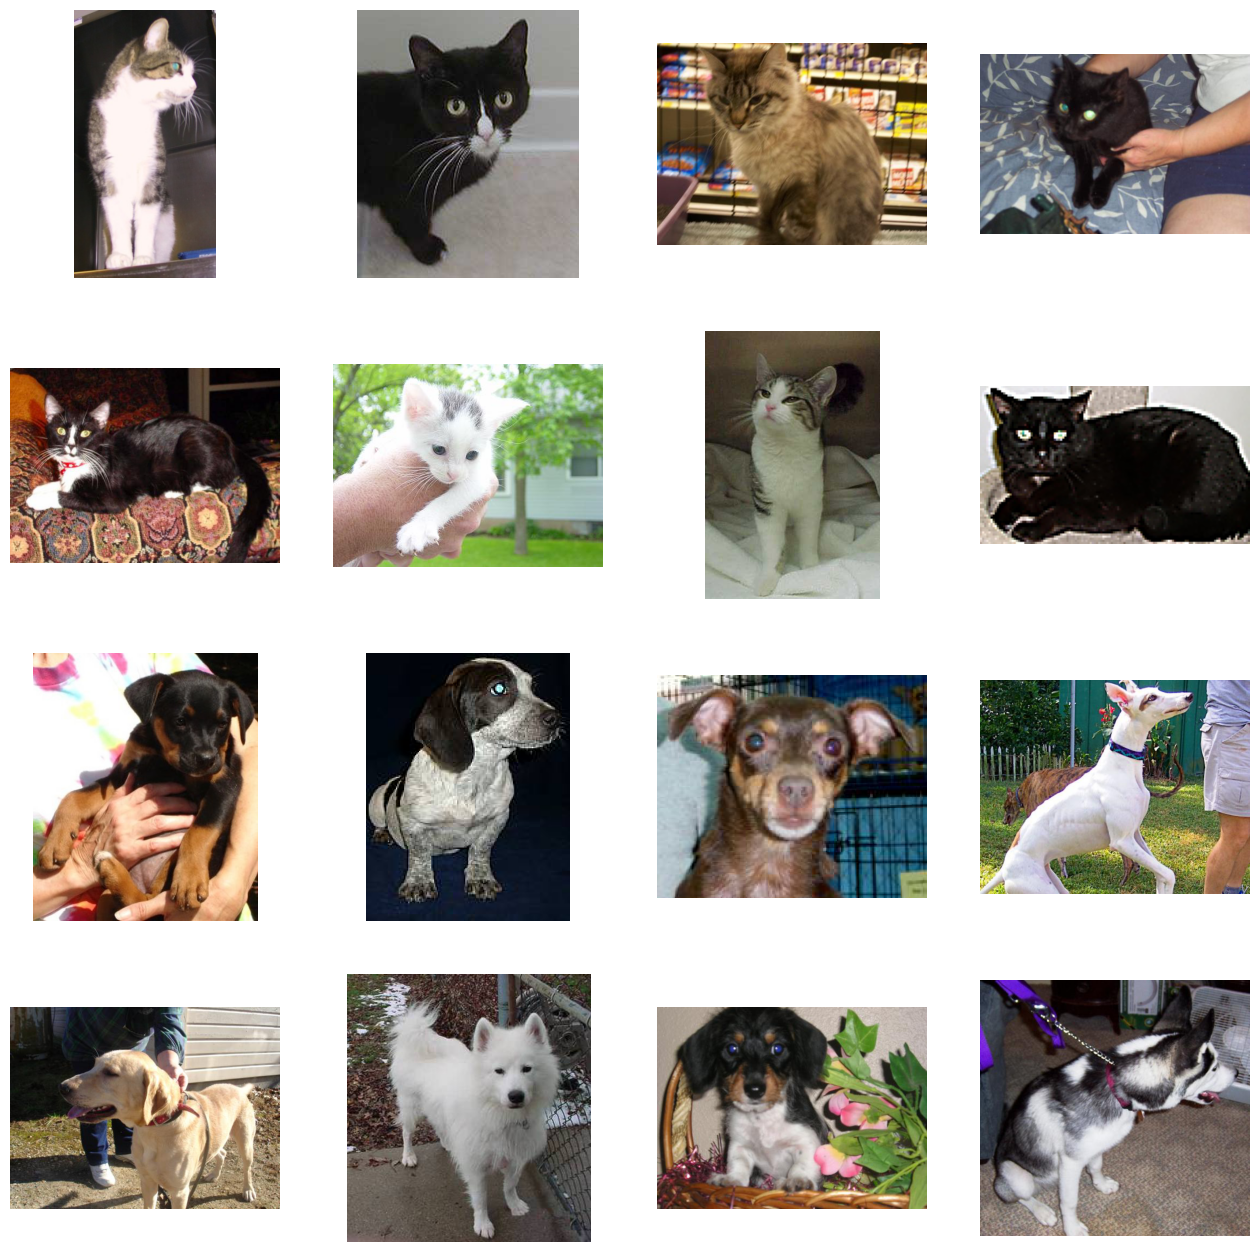

In [5]:
path = './../tmp/CatsDogs'

fig = plt.gcf()
fig.set_size_inches(16, 16)
  
cat_dir = os.path.join(path + "/Cats")
dog_dir = os.path.join(path + "/Dogs")
cat_names = os.listdir(cat_dir)
dog_names = os.listdir(dog_dir)
  
pic_index = 210
  
cat_images = [os.path.join(cat_dir, fname)
              for fname in cat_names[pic_index-8:pic_index]]
dog_images = [os.path.join(dog_dir, fname)
              for fname in dog_names[pic_index-8:pic_index]]
  
for i, img_path in enumerate(cat_images + dog_images):
    sp = plt.subplot(4, 4, i+1)
    sp.axis('Off')
  
    img = mpimg.imread(img_path)
    plt.imshow(img)
  
plt.show()

## **Remove corrupted images**

In [6]:
import glob
# Define the paths
cat_path = glob.glob("./../tmp/CatsDogs/Cats/*.jpg")
dog_path = glob.glob("./../tmp/CatsDogs/Dogs/*.jpg")
paths = list([cat_path, dog_path])

In [7]:
# Remove the images w/ size = 0
for path in paths:
  for filename in path:  
    if os.stat(filename).st_size==0:
      os.remove(filename)

In [8]:
num_skipped = 0
total = 0
for path in paths:
  for filename in path:
    if os.path.exists(filename):
      try:
        total += 1
        fobj = open(filename, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(filename)

print("Deleted %d images" % num_skipped)

Deleted 1588 images


## **Data preparation** 
### Create Dataframe 

In [9]:
df_cat = pd.DataFrame({"img_id": [f"/tmp/CatsDogs/Cats/{i}" for i in os.listdir('/tmp/CatsDogs/Cats')]})
df_cat["label"] = "cat"

df_dog = pd.DataFrame({"img_id": [f"/tmp/CatsDogs/Dogs/{i}" for i in os.listdir('/tmp/CatsDogs/Dogs')]})
df_dog["label"] = "dog"

df = pd.concat([df_cat, df_dog], ignore_index=True)
df = df.sample(frac=1, random_state = 12123).reset_index(drop=True)
df
     

img_id label
0       /tmp/CatsDogs/Dogs/7805.jpg   dog
1       /tmp/CatsDogs/Cats/8457.jpg   cat
2      /tmp/CatsDogs/Cats/11720.jpg   cat
3       /tmp/CatsDogs/Dogs/9134.jpg   dog
4       /tmp/CatsDogs/Cats/7578.jpg   cat
...                             ...   ...
23405   /tmp/CatsDogs/Dogs/3423.jpg   dog
23406   /tmp/CatsDogs/Cats/3007.jpg   cat
23407  /tmp/CatsDogs/Cats/10386.jpg   cat
23408  /tmp/CatsDogs/Cats/12246.jpg   cat
23409   /tmp/CatsDogs/Cats/6405.jpg   cat

[23410 rows x 2 columns]

### Split data in train, validation, and test set

In [11]:
x, test_df = train_test_split(df, test_size = 0.2, train_size = 0.8, random_state = 123)
train_df, validation_df = train_test_split(x, test_size = 0.15, train_size =0.85, random_state=123)

### Generators

In [12]:
image_size = (180,180,3)
image_generator = ImageDataGenerator(rescale=1/255)

In [13]:
train_generator = image_generator.flow_from_dataframe(train_df,
                                                      directory = None,
                                                      x_col = 'img_id',
                                                      y_col = 'label',
                                                      batch_size= 64,
                                                      seed = 123,
                                                      shuffle = True,
                                                      class_mode = 'binary',
                                                      target_size = image_size[0:2],
                                                      color_mode="rgb")

validation_generator = image_generator.flow_from_dataframe(validation_df,
                                                           directory = None,
                                                           x_col = 'img_id',
                                                           y_col = 'label',
                                                           batch_size= 64,
                                                           seed = 123,
                                                           shuffle = True,
                                                           class_mode = 'binary',
                                                           target_size = image_size[0:2],
                                                           color_mode="rgb")

test_generator = image_generator.flow_from_dataframe(test_df,
                                                     directory = None,
                                                     x_col = 'img_id',
                                                     y_col = 'label',
                                                     batch_size= 64,
                                                     seed = 123,
                                                     shuffle = True,
                                                     class_mode = 'binary',
                                                     target_size = image_size[0:2],
                                                     color_mode="rgb")

Found 15918 validated image filenames belonging to 2 classes.
Found 2810 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.


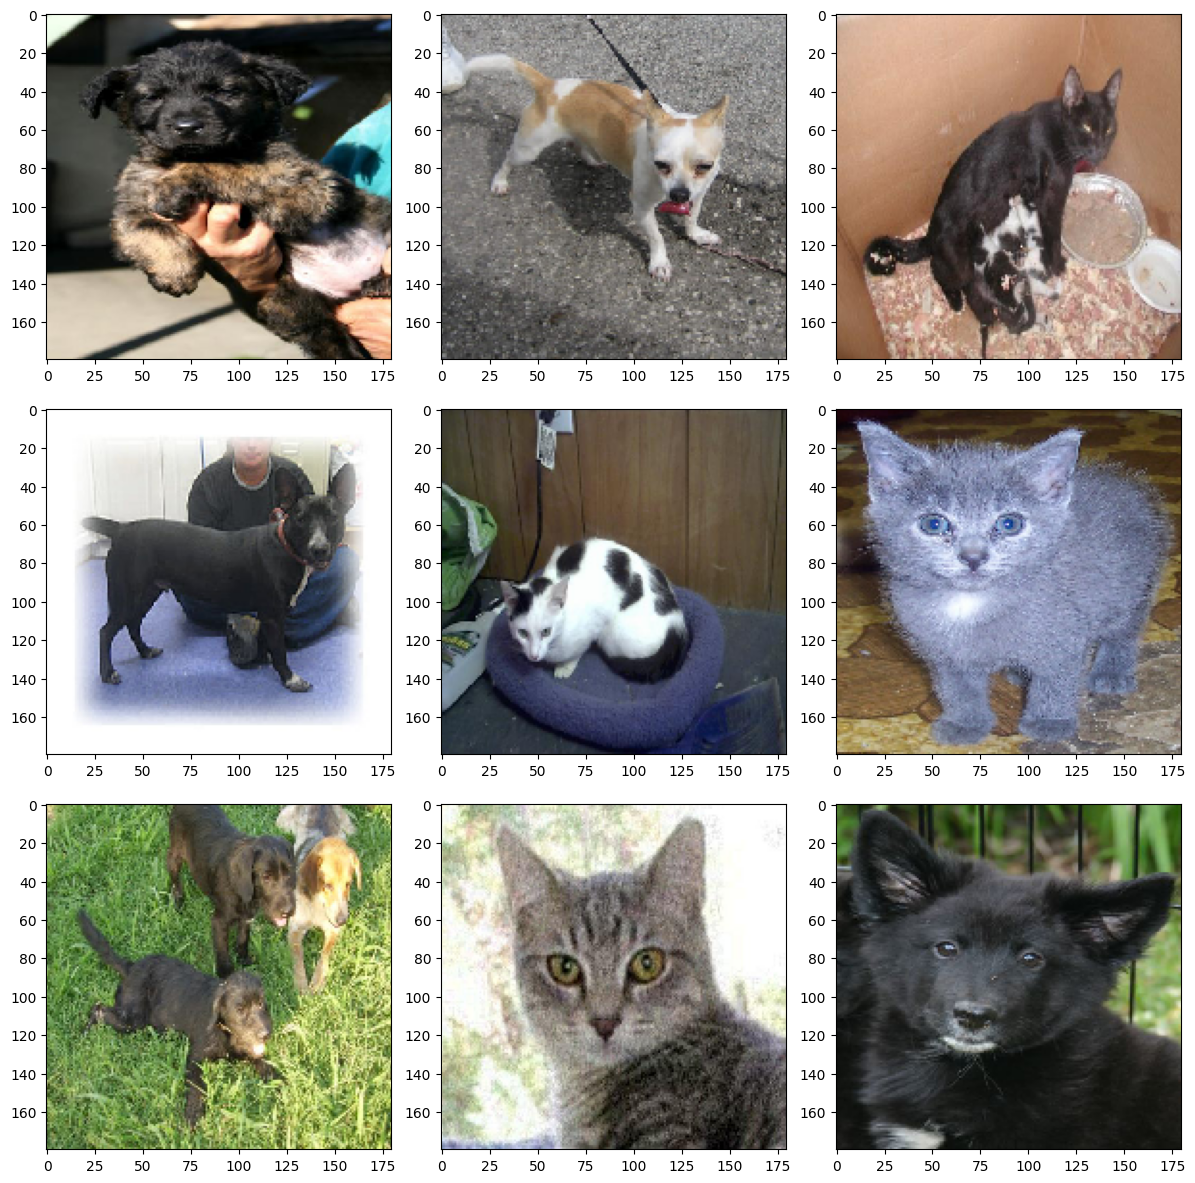

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## **Build different models**

### Model 1

In [ ]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), input_shape = image_size))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))

model1.add(Conv2D(64, (3, 3), input_shape = image_size))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))

model1.add(Conv2D(128, (3, 3), input_shape = image_size))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))

model1.add(Flatten())
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 87, 87, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                    

In [ ]:
model1.compile(optimizer="rmsprop", 
               loss="binary_crossentropy", 
               metrics=["accuracy"])

In [ ]:
tensorboard = keras.callbacks.TensorBoard(log_dir="./results",)

In [ ]:
# Fit, plot and validate the model
step_size_train = validation_generator.n//validation_generator.batch_size
step_size_validation = test_generator.n//test_generator.batch_size

history1 = model1.fit_generator(validation_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=test_generator,
                    validation_steps=step_size_validation,
                    epochs=20,
                    callbacks=[tensorboard])

<ipython-input-18-55e8dc162c25>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(validation_generator,


Epoch 1/20
43/43 [==============================] - 46s 788ms/step - loss: 0.7528 - accuracy: 0.5339 - val_loss: 0.6839 - val_accuracy: 0.5458
Epoch 2/20
43/43 [==============================] - 28s 654ms/step - loss: 0.6817 - accuracy: 0.5801 - val_loss: 0.6650 - val_accuracy: 0.5582
Epoch 3/20
43/43 [==============================] - 32s 744ms/step - loss: 0.6452 - accuracy: 0.6377 - val_loss: 0.6296 - val_accuracy: 0.6171
Epoch 4/20
43/43 [==============================] - 32s 747ms/step - loss: 0.5884 - accuracy: 0.6814 - val_loss: 0.5971 - val_accuracy: 0.6980
Epoch 5/20
43/43 [==============================] - 28s 650ms/step - loss: 0.5592 - accuracy: 0.7163 - val_loss: 0.5690 - val_accuracy: 0.7033
Epoch 6/20
43/43 [==============================] - 31s 735ms/step - loss: 0.4936 - accuracy: 0.7677 - val_loss: 0.6003 - val_accuracy: 0.6973
Epoch 7/20
43/43 [==============================] - 27s 634ms/step - loss: 0.4668 - accuracy: 0.7786 - val_loss: 0.6407 - val_accuracy: 0.6804

Text(0.5, 1.0, 'Model 1: Training vs Test Accuracy')

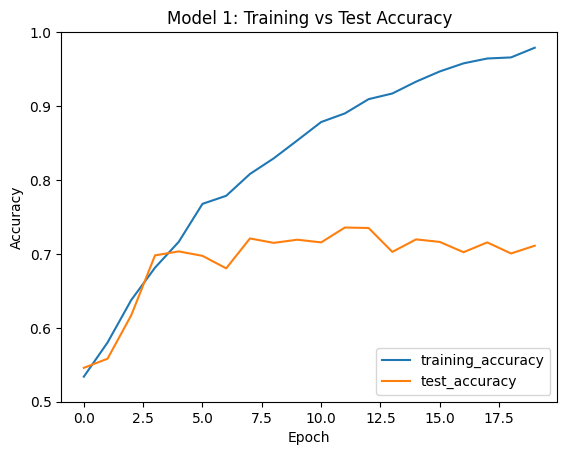

In [ ]:
plt.plot(history1.history['accuracy'], label='training_accuracy')
plt.plot(history1.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 1: Training vs Test Accuracy")

Text(0.5, 1.0, 'Model 1: Training vs Test Loss')

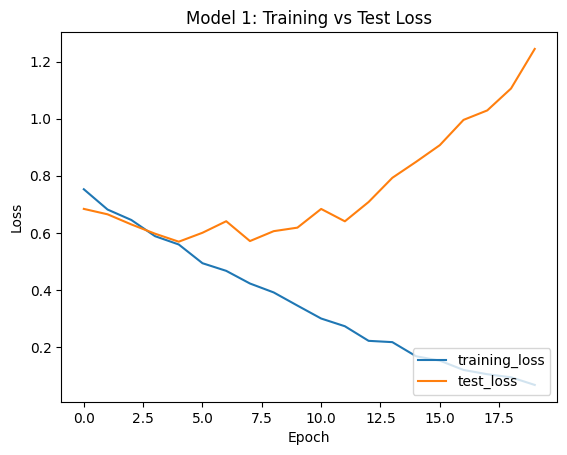

In [ ]:
plt.plot(history1.history['loss'], label='training_loss')
plt.plot(history1.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title("Model 1: Training vs Test Loss")

2/2 [==============================] - 0s 11ms/step


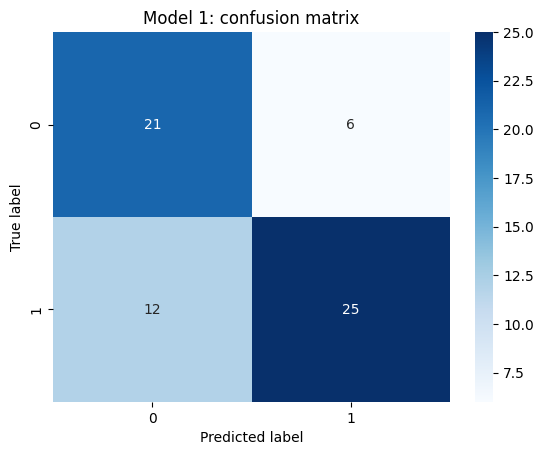

In [ ]:
def round_costum(array):
  list = []
  for x in array:
    if x <0.5:
      x = 0
      list.append(x)
    else:
       x = 1
       list.append(x)
  return np.array(list)

images, labels = test_generator.next()

preds = model1.predict(images)
prediction = (round_costum(preds))

cm = confusion_matrix(labels, prediction) 

sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Model 1: confusion matrix')
plt.show()

In [ ]:
model1.evaluate(test_generator)

74/74 [==============================] - 18s 241ms/step - loss: 1.2442 - accuracy: 0.7108


[1.244201898574829, 0.7108073234558105]

### Model 2 

In [ ]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape = image_size))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Conv2D(64, (3, 3), input_shape = image_size))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Conv2D(128, (3, 3), input_shape = image_size))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))

model2.add(Flatten())
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 87, 87, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [ ]:
model2.compile(optimizer="rmsprop", 
               loss="binary_crossentropy", 
               metrics=["accuracy"])

In [ ]:
# Fit, plot and validate the model
history2 = model2.fit_generator(validation_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=test_generator,
                    validation_steps=step_size_validation,
                    epochs=20,
                    callbacks=[tensorboard])

<ipython-input-26-16be0e82f391>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(validation_generator,


Epoch 1/20
43/43 [==============================] - 28s 624ms/step - loss: 0.7998 - accuracy: 0.5011 - val_loss: 0.6905 - val_accuracy: 0.5013
Epoch 2/20
43/43 [==============================] - 27s 626ms/step - loss: 0.6904 - accuracy: 0.5168 - val_loss: 0.6887 - val_accuracy: 0.6124
Epoch 3/20
43/43 [==============================] - 31s 737ms/step - loss: 0.6876 - accuracy: 0.5772 - val_loss: 0.6543 - val_accuracy: 0.6413
Epoch 4/20
43/43 [==============================] - 26s 624ms/step - loss: 0.6394 - accuracy: 0.6333 - val_loss: 0.6055 - val_accuracy: 0.6667
Epoch 5/20
43/43 [==============================] - 31s 731ms/step - loss: 0.6042 - accuracy: 0.6788 - val_loss: 0.6473 - val_accuracy: 0.6340
Epoch 6/20
43/43 [==============================] - 31s 740ms/step - loss: 0.5766 - accuracy: 0.6996 - val_loss: 0.7361 - val_accuracy: 0.5856
Epoch 7/20
43/43 [==============================] - 26s 615ms/step - loss: 0.5212 - accuracy: 0.7411 - val_loss: 0.5685 - val_accuracy: 0.7076

Text(0.5, 1.0, 'Model 2: Training vs Test Accuracy')

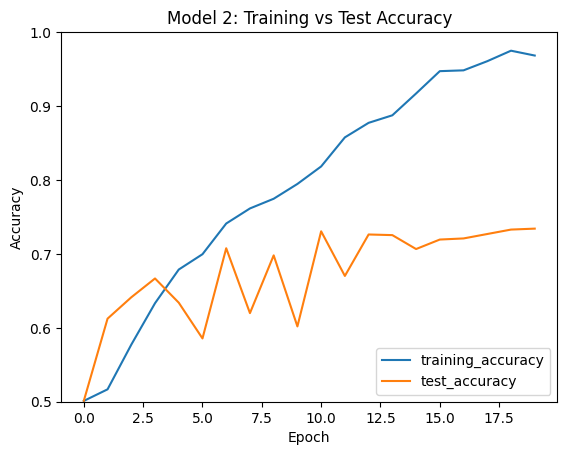

In [ ]:
plt.plot(history2.history['accuracy'], label='training_accuracy')
plt.plot(history2.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 2: Training vs Test Accuracy")

Text(0.5, 1.0, 'Model 2: Training vs Test Loss')

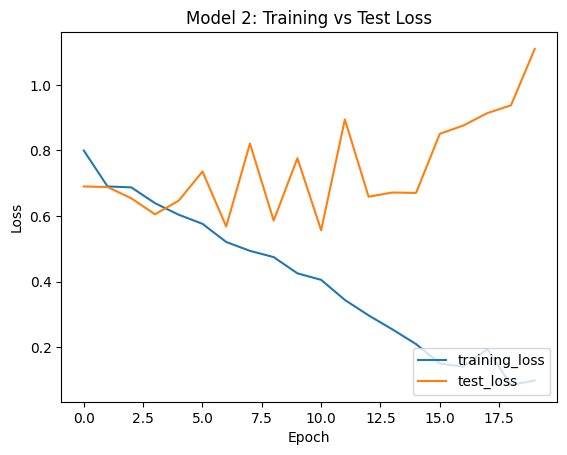

In [ ]:
plt.plot(history2.history['loss'], label='training_loss')
plt.plot(history2.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title("Model 2: Training vs Test Loss")

2/2 [==============================] - 0s 13ms/step


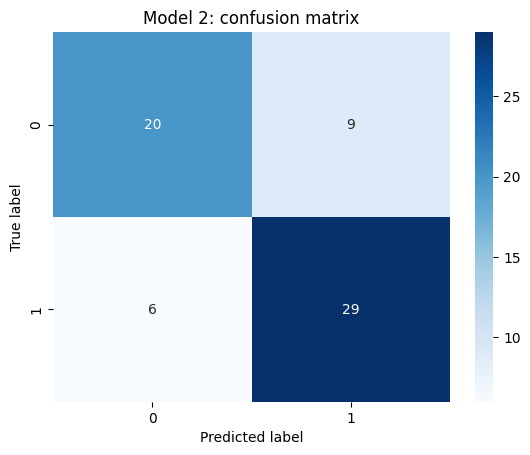

In [ ]:
images, labels = test_generator.next()

preds = model2.predict(images)
prediction = (round_costum(preds))

cm = confusion_matrix(labels, prediction) 

sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Model 2: confusion matrix')
plt.show()

In [ ]:
model2.evaluate(test_generator)

74/74 [==============================] - 16s 217ms/step - loss: 1.1072 - accuracy: 0.7347


[1.1072397232055664, 0.7347287535667419]

### Model 3


In [ ]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), input_shape = image_size))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Conv2D(64, (3, 3), input_shape = image_size))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Conv2D(128, (3, 3), input_shape = image_size))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Conv2D(256, (3, 3), input_shape = image_size))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))

model3.add(Flatten())
model3.add(Dense(128, activation = 'relu'))

model3.add(Flatten())
model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 87, 87, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [ ]:
model3.compile(optimizer="rmsprop", 
               loss="binary_crossentropy", 
               metrics=["accuracy"])

In [ ]:
# Fit, plot and validate the model
history3 = model3.fit_generator(validation_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=test_generator,
                    validation_steps=step_size_validation,
                    epochs=20,
                    callbacks=[tensorboard])

<ipython-input-27-ad7637b998e3>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model3.fit_generator(validation_generator,


Epoch 1/20
43/43 [==============================] - 31s 657ms/step - loss: 0.7056 - accuracy: 0.5138 - val_loss: 0.6920 - val_accuracy: 0.5582
Epoch 2/20
43/43 [==============================] - 27s 634ms/step - loss: 0.6934 - accuracy: 0.5120 - val_loss: 0.6929 - val_accuracy: 0.5006
Epoch 3/20
43/43 [==============================] - 29s 687ms/step - loss: 0.6923 - accuracy: 0.5346 - val_loss: 0.6756 - val_accuracy: 0.5869
Epoch 4/20
43/43 [==============================] - 33s 777ms/step - loss: 0.6852 - accuracy: 0.5652 - val_loss: 0.6662 - val_accuracy: 0.5908
Epoch 5/20
43/43 [==============================] - 28s 661ms/step - loss: 0.6680 - accuracy: 0.6065 - val_loss: 0.6361 - val_accuracy: 0.6423
Epoch 6/20
43/43 [==============================] - 32s 753ms/step - loss: 0.6361 - accuracy: 0.6486 - val_loss: 0.6073 - val_accuracy: 0.6796
Epoch 7/20
43/43 [==============================] - 32s 747ms/step - loss: 0.6012 - accuracy: 0.6766 - val_loss: 0.5954 - val_accuracy: 0.6712

Text(0.5, 1.0, 'Model 3: Training vs Test Accuracy')

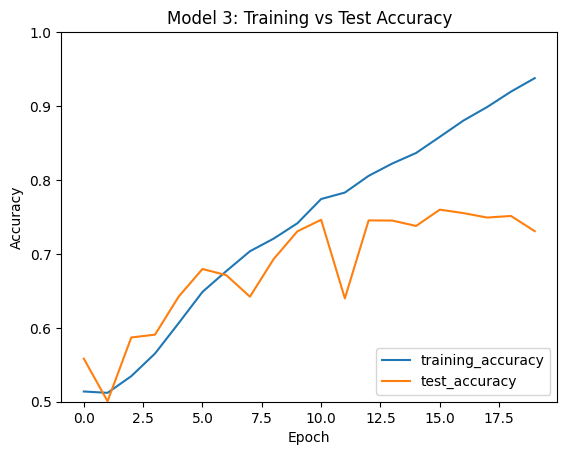

In [ ]:
plt.plot(history3.history['accuracy'], label='training_accuracy')
plt.plot(history3.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 3: Training vs Test Accuracy")

Text(0.5, 1.0, 'Model 3: Training vs Test Loss')

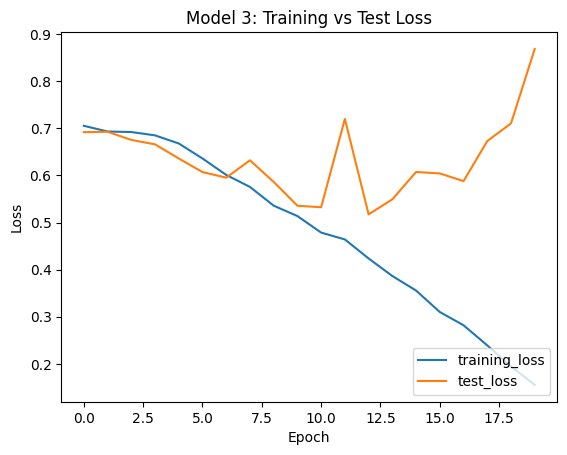

In [ ]:
plt.plot(history3.history['loss'], label='training_loss')
plt.plot(history3.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title("Model 3: Training vs Test Loss")

2/2 [==============================] - 0s 14ms/step


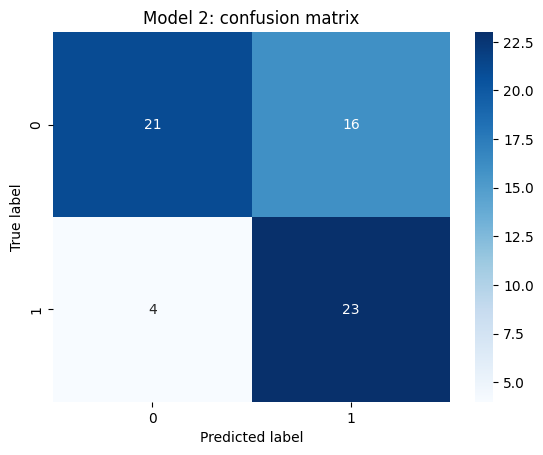

In [ ]:
images, labels = test_generator.next()

preds = model3.predict(images)
prediction = (round_costum(preds))

cm = confusion_matrix(labels, prediction) 

sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Model 2: confusion matrix')
plt.show()

In [ ]:
model3.evaluate(test_generator)

74/74 [==============================] - 17s 228ms/step - loss: 0.8672 - accuracy: 0.7313


[0.8671784400939941, 0.7313113808631897]

## Model 3 with early stopping

In [ ]:
# Model fit
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model3_checkpoint = ModelCheckpoint("Model3", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")


history3es =  model3.fit(train_generator,
                         validation_data=validation_generator,
                         epochs = 20, 
                         use_multiprocessing=False, 
                         verbose = 1,
                         callbacks=[callback, model3_checkpoint]
)

Epoch 1/20
249/249 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.7774
Epoch 1: val_accuracy improved from -inf to 0.88078, saving model to Model3


249/249 [==============================] - 81s 324ms/step - loss: 0.4737 - accuracy: 0.7774 - val_loss: 0.3051 - val_accuracy: 0.8808
Epoch 2/20
249/249 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8282
Epoch 2: val_accuracy improved from 0.88078 to 0.91103, saving model to Model3


249/249 [==============================] - 87s 349ms/step - loss: 0.3867 - accuracy: 0.8282 - val_loss: 0.2612 - val_accuracy: 0.9110
Epoch 3/20
249/249 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8609
Epoch 3: val_accuracy did not improve from 0.91103
249/249 [==============================] - 75s 301ms/step - loss: 0.3182 - accuracy: 0.8609 - val_loss: 0.2636 - val_accuracy: 0.8968
Epoch 4/20
249/249 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.8924
Epoch 4: val_accuracy did not improve from 0.91103
249/249 [==============================] - 73s 292ms/step - loss: 0.2506 - accuracy: 0.8924 - val_loss: 0.2197 - val_accuracy: 0.9096
Epoch 5/20
249/249 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9239
Epoch 5: val_accuracy did not improve from 0.91103
249/249 [==============================] - 73s 291ms/step - loss: 0.1870 - accuracy: 0.9239 - val_loss: 0.2378 - val_accuracy: 0.8993


Text(0.5, 1.0, 'Model 3: Training vs Test Accuracy')

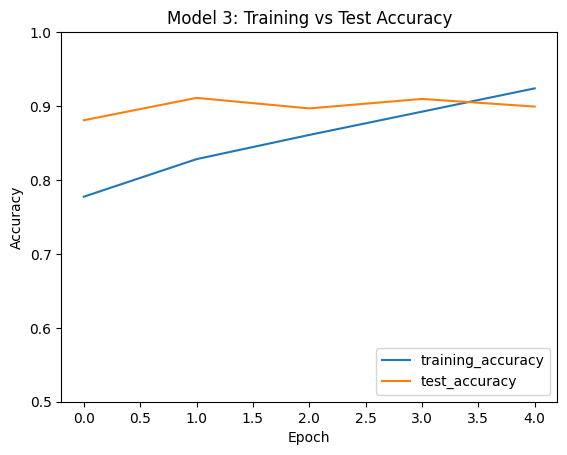

In [ ]:
plt.plot(history3es.history['accuracy'], label='training_accuracy')
plt.plot(history3es.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 3: Training vs Test Accuracy")

Text(0.5, 1.0, 'Model 3: Training vs Test Loss')

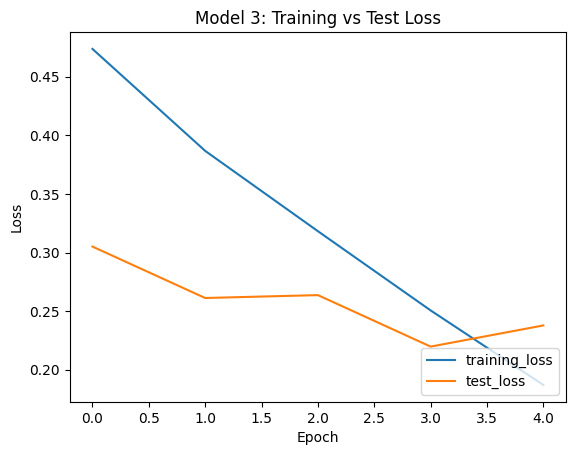

In [ ]:
plt.plot(history3es.history['loss'], label='training_loss')
plt.plot(history3es.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title("Model 3: Training vs Test Loss")

In [ ]:
model3.evaluate(test_generator)

74/74 [==============================] - 17s 225ms/step - loss: 0.3903 - accuracy: 0.8479


[0.3902698755264282, 0.8479282259941101]

### Model 4

In [ ]:
# Adding data augmentation 

image_generator = ImageDataGenerator(rescale=1/255, 
                                     zoom_range=0.15, 
                                     width_shift_range=0.1, 
                                     height_shift_range=0.1, 
                                     horizontal_flip=True, 
                                     validation_split=0.2) 

train_generator_aug = image_generator.flow_from_dataframe(train_df,
                                                          directory = None,
                                                          x_col = 'img_id',
                                                          y_col = 'label',
                                                          batch_size = 64,
                                                          shuffle=True,
                                                          class_mode = 'binary',
                                                          target_size = image_size[0:2],
                                                          color_mode="rgb")

validation_generator_aug = image_generator.flow_from_dataframe(validation_df,
                                                               directory = None,
                                                               x_col = 'img_id',
                                                               y_col = 'label',
                                                               batch_size = 64,
                                                               shuffle=True,
                                                               class_mode = 'binary',
                                                               target_size = image_size[0:2],
                                                               color_mode="rgb")

test_generator_aug = image_generator.flow_from_dataframe(test_df, 
                                                          directory = None,
                                                          x_col = 'img_id',
                                                          y_col = 'label',
                                                          batch_size = 64,
                                                          shuffle=True,
                                                          class_mode = 'binary',
                                                          target_size = image_size[0:2],
                                                          color_mode="rgb")

Found 15918 validated image filenames belonging to 2 classes.
Found 2810 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.


In [ ]:
model4 = Sequential()

model4.add(Conv2D(32, (3, 3), input_shape = image_size))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Conv2D(64, (3, 3), input_shape = image_size))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Conv2D(128, (3, 3), input_shape = image_size))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Conv2D(256, (3, 3), input_shape = image_size))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Flatten())
model4.add(Dense(128, activation = 'relu'))

model4.add(Flatten())
model4.add(Dense(1))
model4.add(Activation('sigmoid'))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 activation_9 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 activation_10 (Activation)  (None, 87, 87, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [ ]:
model4.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Model fit
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model4_checkpoint = ModelCheckpoint("Model4", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")


history4 =  model4.fit(train_generator,
                         validation_data=validation_generator,
                         epochs = 20, 
                         use_multiprocessing=False, 
                         verbose = 1,
                         callbacks=[callback, model3_checkpoint]
)

Epoch 1/20
249/249 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.5614
Epoch 1: val_accuracy did not improve from 0.91103
249/249 [==============================] - 86s 338ms/step - loss: 0.7010 - accuracy: 0.5614 - val_loss: 0.6122 - val_accuracy: 0.6737
Epoch 2/20
249/249 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.6966
Epoch 2: val_accuracy did not improve from 0.91103
249/249 [==============================] - 75s 300ms/step - loss: 0.5726 - accuracy: 0.6966 - val_loss: 0.5129 - val_accuracy: 0.7452
Epoch 3/20
249/249 [==============================] - ETA: 0s - loss: 0.4987 - accuracy: 0.7532
Epoch 3: val_accuracy did not improve from 0.91103
249/249 [==============================] - 71s 287ms/step - loss: 0.4987 - accuracy: 0.7532 - val_loss: 0.4911 - val_accuracy: 0.7605
Epoch 4/20
249/249 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.7948
Epoch 4: val_accuracy did not improve from 0.91103
249/249 [=

Text(0.5, 1.0, 'Model 4: Training vs Test Accuracy')

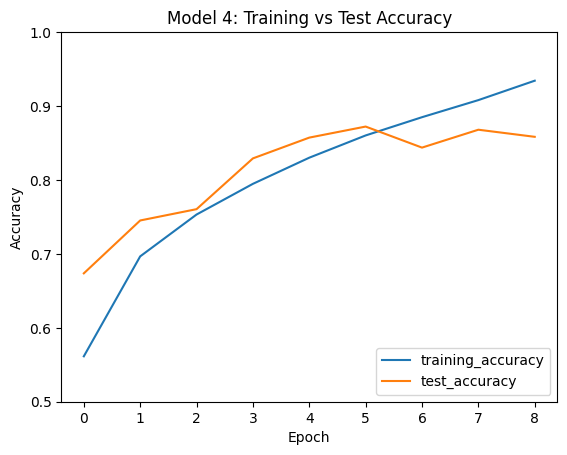

In [ ]:
plt.plot(history4.history['accuracy'], label='training_accuracy')
plt.plot(history4.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model 4: Training vs Test Accuracy")

Text(0.5, 1.0, 'Model 4: Training vs Test Loss')

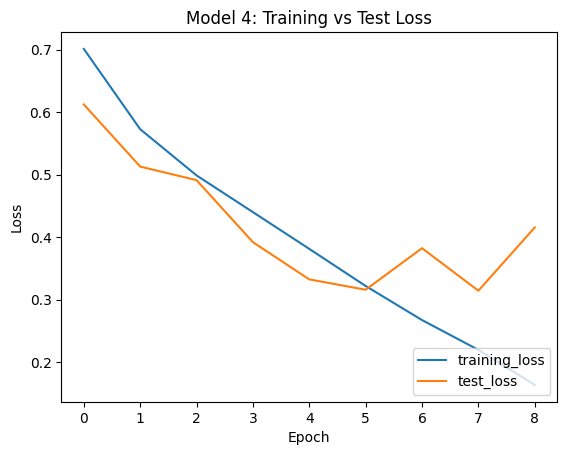

In [ ]:
plt.plot(history4.history['loss'], label='training_loss')
plt.plot(history4.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title("Model 4: Training vs Test Loss")

2/2 [==============================] - 0s 18ms/step


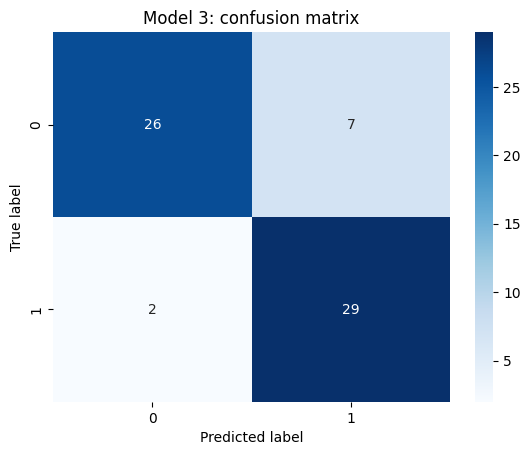

In [ ]:
images, labels = test_generator.next()

preds = model4.predict(images)
prediction = (round_costum(preds))

cm = confusion_matrix(labels, prediction) 

sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Model 3: confusion matrix')
plt.show()

In [ ]:
model4.evaluate(test_generator)

74/74 [==============================] - 18s 245ms/step - loss: 0.3364 - accuracy: 0.8509


[0.33640405535697937, 0.8509184122085571]

### Model 5

## **Cross Validation**

In [14]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.12, 
                                   random_state = 123)

folds = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [15]:
# Definition of cross validation model

image_size = (180,180,3)

def model_cv_definition():
  
  model_cv = Sequential()
  
  model_cv.add(Conv2D(32, (3, 3), input_shape = image_size))
  model_cv.add(Activation('relu'))
  model_cv.add(MaxPooling2D(pool_size = (2, 2)))
  
  model_cv.add(Conv2D(64, (3, 3), input_shape = image_size))
  model_cv.add(Activation('relu'))
  model_cv.add(MaxPooling2D(pool_size = (2, 2)))
  
  model_cv.add(Conv2D(128, (3, 3), input_shape = image_size))
  model_cv.add(Activation('relu'))
  model_cv.add(MaxPooling2D(pool_size = (2, 2)))
  
  model_cv.add(Conv2D(256, (3, 3), input_shape = image_size))
  model_cv.add(Activation('relu'))
  model_cv.add(MaxPooling2D(pool_size = (2, 2)))
  
  model_cv.add(Flatten())
  model_cv.add(Dense(128, activation = 'relu'))
  
  model_cv.add(Flatten())
  model_cv.add(Dense(1))
  model_cv.add(Activation('sigmoid'))
  
  return model_cv


In [16]:
# Define generators
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) 
test_image_generator = ImageDataGenerator(rescale=1/255)
count = 1 # To keep track of the fold count

# Define checkpoint for the model

model_cv_checkpoint = ModelCheckpoint("Modelcv", 
                                      monitor="val_accuracy", 
                                      verbose=1,
                                      save_best_only=True, 
                                      mode="max")

# Cross validation

for train_index, inner_test_index in folds.split(train_df):
    training_data = train_df.iloc[train_index]
    inner_test_data = train_df.iloc[inner_test_index]


    train_generator = image_generator.flow_from_dataframe(train_df,
                                                          directory = None,
                                                          x_col ='img_id',
                                                          y_col ='label',
                                                          target_size = image_size[0:2],
                                                          class_mode ='binary',
                                                          batch_size = 64,
                                                          color_mode = 'rgb')
    
    inner_test = image_generator.flow_from_dataframe(train_df,
                                                     directory = None,
                                                     x_col ='img_id',
                                                     y_col ='label',
                                                     target_size = image_size[0:2],
                                                     class_mode ='binary',
                                                     batch_size = 64,
                                                     color_mode = 'rgb')

    outer_test = test_image_generator.flow_from_dataframe(train_df,
                                                          directory = None,
                                                          x_col ='img_id',
                                                          y_col ='label',
                                                          target_size = image_size[0:2],
                                                          class_mode ='binary',
                                                          batch_size = 64,
                                                          color_mode = 'rgb')



    # Define model 

    model_cv = model_cv_definition()

    # Compile the model

    model_cv.compile(optimizer="rmsprop",
                     loss='binary_crossentropy',
                     metrics=['accuracy'])



     # Model FIT
    
    history_cv =  model_cv.fit(train_generator,
                               validation_data = inner_test,
                               epochs = 8, 
                               use_multiprocessing=False, 
                               workers = 20,
                               verbose = 1,
                               callbacks=[model_cv_checkpoint]
                               )

    # Free GPU 

    tf.keras.backend.clear_session()


Found 14007 validated image filenames belonging to 2 classes.
Found 14007 validated image filenames belonging to 2 classes.
Found 14007 validated image filenames belonging to 2 classes.
Epoch 1/8
219/219 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5694
Epoch 1: val_accuracy improved from -inf to 0.65803, saving model to Modelcv


219/219 [==============================] - 109s 431ms/step - loss: 0.6884 - accuracy: 0.5694 - val_loss: 0.6055 - val_accuracy: 0.6580
Epoch 2/8
219/219 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7079
Epoch 2: val_accuracy improved from 0.65803 to 0.76490, saving model to Modelcv


219/219 [==============================] - 97s 434ms/step - loss: 0.5613 - accuracy: 0.7079 - val_loss: 0.5007 - val_accuracy: 0.7649
Epoch 3/8
219/219 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.7630
Epoch 3: val_accuracy improved from 0.76490 to 0.81331, saving model to Modelcv


219/219 [==============================] - 129s 583ms/step - loss: 0.4933 - accuracy: 0.7630 - val_loss: 0.4242 - val_accuracy: 0.8133
Epoch 4/8
219/219 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.8041
Epoch 4: val_accuracy did not improve from 0.81331
219/219 [==============================] - 96s 430ms/step - loss: 0.4303 - accuracy: 0.8041 - val_loss: 0.4171 - val_accuracy: 0.8014
Epoch 5/8
219/219 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.8315
Epoch 5: val_accuracy improved from 0.81331 to 0.87171, saving model to Modelcv


219/219 [==============================] - 100s 448ms/step - loss: 0.3787 - accuracy: 0.8315 - val_loss: 0.3057 - val_accuracy: 0.8717
Epoch 6/8
219/219 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8586
Epoch 6: val_accuracy improved from 0.87171 to 0.90569, saving model to Modelcv


219/219 [==============================] - 131s 590ms/step - loss: 0.3250 - accuracy: 0.8586 - val_loss: 0.2357 - val_accuracy: 0.9057
Epoch 7/8
219/219 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.8828
Epoch 7: val_accuracy improved from 0.90569 to 0.92225, saving model to Modelcv


219/219 [==============================] - 130s 589ms/step - loss: 0.2722 - accuracy: 0.8828 - val_loss: 0.2045 - val_accuracy: 0.9223
Epoch 8/8
219/219 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9120
Epoch 8: val_accuracy improved from 0.92225 to 0.94082, saving model to Modelcv


219/219 [==============================] - 99s 439ms/step - loss: 0.2165 - accuracy: 0.9120 - val_loss: 0.1514 - val_accuracy: 0.9408
Found 14007 validated image filenames belonging to 2 classes.
Found 14007 validated image filenames belonging to 2 classes.
Found 14007 validated image filenames belonging to 2 classes.
Epoch 1/8
219/219 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5709
Epoch 1: val_accuracy did not improve from 0.94082
219/219 [==============================] - 100s 443ms/step - loss: 0.6892 - accuracy: 0.5709 - val_loss: 0.5917 - val_accuracy: 0.6885
Epoch 2/8
219/219 [==============================] - ETA: 0s - loss: 0.5691 - accuracy: 0.6987
Epoch 2: val_accuracy did not improve from 0.94082
219/219 [==============================] - 129s 582ms/step - loss: 0.5691 - accuracy: 0.6987 - val_loss: 0.5187 - val_accuracy: 0.7396
Epoch 3/8
219/219 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7651
Epoch 3: val_accuracy d

219/219 [==============================] - 130s 589ms/step - loss: 0.2295 - accuracy: 0.9026 - val_loss: 0.1440 - val_accuracy: 0.9498


Text(0.5, 1.0, 'Model with cross validation: Training vs Test Accuracy')

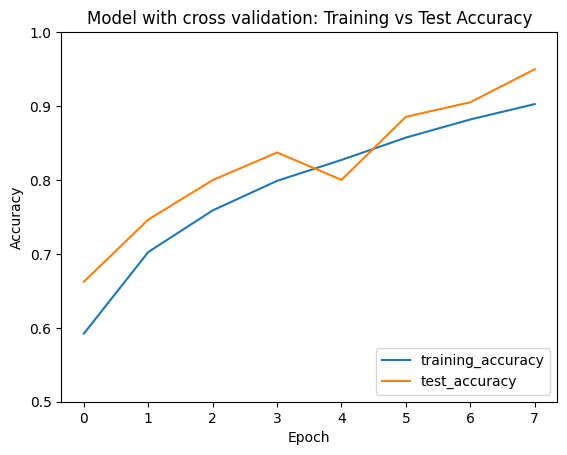

In [17]:
plt.plot(history_cv.history['accuracy'], label='training_accuracy')
plt.plot(history_cv.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Model with cross validation: Training vs Test Accuracy")

Text(0.5, 1.0, 'Model with cross validation: Training vs Test Loss')

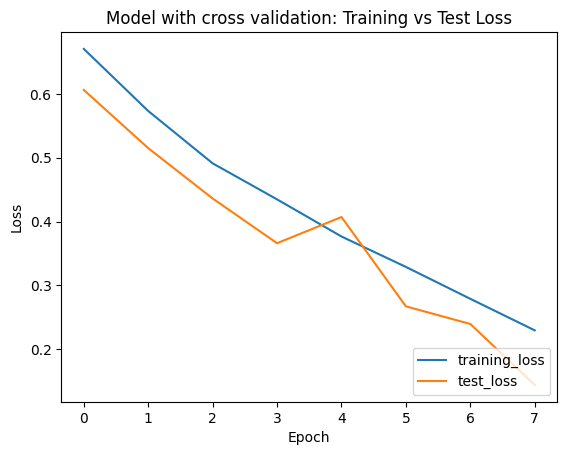

In [18]:
plt.plot(history_cv.history['loss'], label='training_loss')
plt.plot(history_cv.history['val_loss'], label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title("Model with cross validation: Training vs Test Loss")

In [19]:
model_cv.evaluate(test_generator)

74/74 [==============================] - 21s 273ms/step - loss: 0.3624 - accuracy: 0.8469


[0.3624486029148102, 0.8468602895736694]